# チューニングの自動化
- 前項で最適なパラメータを求めたことから、それらを自動的にやってくれる便利機能についてのまとめ。
- 主に二種類を今回は紹介
### グリッドサーチ
- 調整したいハイパーパラメータを複数指定して、最適解を探してくれる。
- 文字、整数、Ture、Falseなどの値をとるパラメータに向いている。
- ただし、数の多いパラメータを一度にチューニングするのには不向き。
- ※プログラム実行時間が長いから注意
### ランダムサーチ
- 値の候補をある程度範囲で指定し、それを確率的に探索しモデル評価を繰り返すことで最適解を探す。
- 値の範囲の指定はパラメータの確立関数を指定する。今回はscipyの内部モジュールを使用

In [3]:
#グリッドサーチ

### ライブラリのインポート
import scipy.stats
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix

### 探索するパラメータ空間
def param():
    ret = {
        'C':[1, 10, 100],
        'kernel':['rbf', 'linear', 'poly'],
        'degree':np.arange(1, 6, 1),
        'gamma':np.linspace(0.01, 1.0, 50)
    }
    return ret

if __name__ == '__main__':
  # データの準備
    x = load_iris().data
    y = load_iris().target

  # 25%分のデータを除けておく
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

  # GridSearchCVのインスタンスを作成&学習&スコア記録
    gscv = GridSearchCV(SVC(), param(), cv=4, verbose=0,iid=False)#verboseは0で何もなし、1,2で進捗が見える。
    gscv.fit(x_train, y_train)

    best_param = gscv.best_params_
    print("パラメータ:{}".format(best_param))
    

パラメータ:{'C': 10, 'degree': 1, 'gamma': 0.5555102040816327, 'kernel': 'poly'}


(1797, 64)


<Figure size 432x288 with 0 Axes>

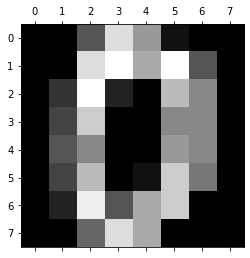

In [5]:
#使用するデータの確認用
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.data.shape)
plt.gray() 
plt.matshow(digits.images[0]) 
plt.show() 

In [12]:
import scipy.stats
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV as GS
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

data = load_digits()
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1)) # 8x8の配列から64次元のベクトルに変換
y = digits.target


X = X.astype("float")

train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=42)


#パラメータのセッティング
model_param_set_grid = {SVC(): {
    "gamma":["auto"],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "C": [10 ** i for i in range(-5, 5)],
    "decision_function_shape":["ovr", "ovo"],
    "random_state":[42]}}

max_score = 0
best_param = None

#グリッドサーチで探す
for model, param in model_param_set_grid.items():
    clf = GS(model, param, cv=5)
    clf.fit(train_X, train_y)
    pred_y = clf.predict(test_X)
    score = f1_score(test_y, pred_y, average="micro")
    if max_score < score:
        max_score = score
        best_model = model.__class__.__name__
        best_param = clf.best_params_
print("パラメータ:{}".format(best_param))
print("ベストスコア",max_score)
svm = SVC(gamma="auto")
svm.fit(train_X, train_y)
print()
print("調整なし")
print(svm.score(test_X, test_y))

パラメータ:{'C': 0.0001, 'decision_function_shape': 'ovr', 'gamma': 'auto', 'kernel': 'poly', 'random_state': 42}
ベストスコア 0.9888888888888889

調整なし
0.5222222222222223


In [39]:
### ライブラリのインポート
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix

### 探索するパラメータ空間
def param():
    ret = {
        'C':[1, 10, 100],
        'kernel':['rbf', 'linear', 'poly'],
        'degree':np.arange(1, 6, 1),
        'gamma':np.linspace(0.01, 1.0, 50)
    }
    return ret

if __name__ == '__main__':
  # データの準備
    x = load_iris().data
    y = load_iris().target

  # 25%分のデータを除けておく
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

  # GridSearchCVのインスタンスを作成&学習&スコア記録
    gscv = GridSearchCV(SVC(), param(), cv=4, verbose=0,iid=False,return_train_score=True)#verboseは0で何もなし、1,2で進捗が見える。
    gscv.fit(x_train, y_train)

  # スコアの一覧を取得
    gs_result = pd.DataFrame.from_dict(gscv.cv_results_)
    gs_result.to_csv('gs_result.csv')

  # 最高性能のモデルを取得し、テストデータを分類
    best = gscv.best_estimator_
    pred = best.predict(x_test)

  # 混同行列を出力
    print(confusion_matrix(y_test, pred))
    print(best)

[[ 9  0  0]
 [ 0 11  1]
 [ 0  1 16]]
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=1, gamma=0.7979591836734694,
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


In [4]:
#ランダムサーチ
import scipy.stats
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV as RSCV, train_test_split
from sklearn.metrics import f1_score

In [6]:
digits = load_digits()
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1)) # 8x8の配列から64次元のベクトルに変換
y = digits.target


X = X.astype("float")

train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=42)

In [9]:
#パラメータの値の候補を設定
model_param_set_random = {SVC():{
    "gamma":["auto"],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "C": scipy.stats.randint(0, 100),
    "decision_function_shape": ["ovr", "ovo"],
    "random_state": scipy.stats.randint(0, 100)
}}

In [10]:
max_score = 0
best_param = None

In [11]:
for model, param in model_param_set_random.items():
    clf = RSCV(model, param)
    clf.fit(train_X, train_y)
    pred_y = clf.predict(test_X)
    score = f1_score(test_y, pred_y, average="micro")
    if max_score < score:
        max_score = score
        best_model = model.__class__.__name__
        best_param = clf.best_params_
print("パラメータ:{}".format(best_param))
print("ベストスコア",max_score)
svm = SVC(gamma="auto")
svm.fit(train_X, train_y)
print()
print("調整なし")
print(svm.score(test_X, test_y))

パラメータ:{'C': 37, 'decision_function_shape': 'ovr', 'kernel': 'poly', 'random_state': 15}
ベストスコア 0.9888888888888889

調整なし
0.5222222222222223
